# TabNet

TabNet is a deep learning architecture designed for processing tabular data. It leverages a unique sequential attention mechanism to dynamically select the most informative features. This can be achieved through a feature masking mechanism, ensuring that only relevant features are used at each decision step. Therefore, TabNet can indicate which features contribute the most to each decision step. This structured feature selection process makes TabNet  efficient and inherently interpretable. Moreover, the attention mechanism enables feature importance visualization, making it easier to understand the model’s reasoning [1]. For more details on TabNet, you can refer to [this paper](https://arxiv.org/pdf/1908.07442.pdf).

## 1. Importing Required Libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## 2. Data Preprocessing 
In this notebook, we utilize the US-130 dataset, a structured medical dataset containing various clinical measurements collected from patients diagnosed with diabetes from 1999 to 2008. This dataset provides valuable information about patient health indicators, clinical variables, and potential risk factors associated with diabetes. These include demographic information, lab results, diabetes-related indicators, and medication history. Machine learning models can be applied to this dataset to estimate diabetes-related outcomes. e.g., hospital readmission prediction. To find more information, you can refer to [this link](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008).

In [4]:
# preprocessing function
def process_us_130_csv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function for new data downloaded from UCL
    """
    age_transform = { '[0-10)' : 5,
                      '[10-20)' : 15,
                      '[20-30)' : 25,
                      '[30-40)' : 35,
                      '[40-50)' : 45,
                      '[50-60)' : 55,
                      '[60-70)' : 65,
                      '[70-80)' : 75,
                      '[80-90)' : 85,
                      '[90-100)' : 95
                    }
    
    #Apply column specific transformations
    df['age'] = df['age'].apply(lambda x : age_transform[x])
    df['diag_1'] = df['diag_1'].apply(lambda x: x[:x.find(".")])
    df['diag_2'] = df['diag_2'].apply(lambda x: x[:x.find(".")])
    df['diag_3'] = df['diag_3'].apply(lambda x: x[:x.find(".")])
    # binarizing the target values
    df['readmitted_binarized'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0)
    # imputing missing values
    df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x: 'Unknown' if type(x) != str else x)
    df['A1Cresult'] = df['A1Cresult'].apply(lambda x: 'Unknown' if type(x) != str else x)

    #Drop columns which are not needed
    df = df.drop(['encounter_id', 'patient_nbr', 'examide',
                  'readmitted','weight','payer_code', 'medical_specialty'], axis=1)

    #Frequency encoding of categorical columns: The categorical variables are converted into numerical features by replacing each unique value in a column with its corresponding frequency in that column.
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()    
    for cat_column in categorical_columns:
        frequency_encoding = df[cat_column].value_counts(normalize=True).to_dict()
        df[f'encoded_{cat_column}'] = df[cat_column].map(frequency_encoding)
        df = df.drop(cat_column, axis=1)

    return df

In [6]:
# data loading and preparation
data = pd.read_csv("diabetic_data.csv")
df = process_us_130_csv(data)
df.index=range(df.shape[0])
df.head() # printing the first five rows of the dataset

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,encoded_tolazamide,encoded_citoglipton,encoded_insulin,encoded_glyburide-metformin,encoded_glipizide-metformin,encoded_glimepiride-pioglitazone,encoded_metformin-rosiglitazone,encoded_metformin-pioglitazone,encoded_change,encoded_diabetesMed
0,5,6,25,1,1,41,0,1,0,0,...,0.999617,1.0,0.465607,0.993063,0.999872,0.99999,0.99998,0.99999,0.538048,0.229969
1,15,1,1,7,3,59,0,18,0,0,...,0.999617,1.0,0.111196,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031
2,25,1,1,7,2,11,5,13,2,0,...,0.999617,1.0,0.465607,0.993063,0.999872,0.99999,0.99998,0.99999,0.538048,0.770031
3,35,1,1,7,2,44,1,16,0,0,...,0.999617,1.0,0.111196,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031
4,45,1,1,7,1,51,0,8,0,0,...,0.999617,1.0,0.303137,0.993063,0.999872,0.99999,0.99998,0.99999,0.461952,0.770031


## 3. Model Training and Evaluation

We apply 5-fold cross-validation, where the dataset is split into five subsets (folds). A TabNet classifier is trained on four folds while the remaining fold serves as the test set, ensuring that each fold is used for evaluation exactly once. At each iteration, the model is trained to predict the risk of readmission within 30 days of discharge. The evaluation metrics are calculated on the respective test folds, and the final performance is reported as the mean of the test results across all five folds, providing a more robust and generalized assessment of the model’s performance.

In [16]:
# https://github.com/dreamquark-ai/tabnet
X , y = df.drop("readmitted_binarized",axis=1) , df["readmitted_binarized"]
k = 5 # numer of folds in cross-validation
indices = np.arange(len(X))
np.random.shuffle(indices)
folds = np.array_split(indices, k)
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i in range(k):
    print(f"Fold {i}")
    test_idx = folds[i]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Use all other folds as the training set
    train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    clf = TabNetClassifier()

    clf.fit(X_train.values, y_train.values,max_epochs=20)
    y_pred = clf.predict(X_test.values)

    y_prob = clf.predict_proba(X_test.values)[:,1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test,y_pred)
    test_precision = precision_score(y_test,y_pred)
    test_recall = recall_score(y_test,y_pred)
    
    auc_scores.append(test_auc)
    f1_scores.append(test_f1)
    recall_scores.append(test_precision)
    precision_scores.append(test_recall)
    
print("mean_test_auc",np.mean(auc_scores))
print("mean_test_f1",np.mean(f1_scores))
print("mean_test_precision",np.mean(precision_scores))
print("mean_test_recall",np.mean(recall_scores))

    

Fold 0
epoch 0  | loss: 0.39632 |  0:00:03s
epoch 1  | loss: 0.34989 |  0:00:07s
epoch 2  | loss: 0.34805 |  0:00:11s
epoch 3  | loss: 0.34576 |  0:00:15s
epoch 4  | loss: 0.34271 |  0:00:19s
epoch 5  | loss: 0.34118 |  0:00:23s
epoch 6  | loss: 0.34078 |  0:00:27s
epoch 7  | loss: 0.34083 |  0:00:31s
epoch 8  | loss: 0.34033 |  0:00:35s
epoch 9  | loss: 0.33971 |  0:00:39s
epoch 10 | loss: 0.33937 |  0:00:43s
epoch 11 | loss: 0.33857 |  0:00:47s
epoch 12 | loss: 0.33806 |  0:00:51s
epoch 13 | loss: 0.33839 |  0:00:55s
epoch 14 | loss: 0.33807 |  0:00:59s
epoch 15 | loss: 0.33749 |  0:01:03s
epoch 16 | loss: 0.33724 |  0:01:06s
epoch 17 | loss: 0.33764 |  0:01:10s
epoch 18 | loss: 0.3371  |  0:01:14s
epoch 19 | loss: 0.33765 |  0:01:18s
Fold 1
epoch 0  | loss: 0.4041  |  0:00:03s
epoch 1  | loss: 0.34586 |  0:00:07s
epoch 2  | loss: 0.34301 |  0:00:11s
epoch 3  | loss: 0.34224 |  0:00:15s
epoch 4  | loss: 0.34156 |  0:00:19s
epoch 5  | loss: 0.34171 |  0:00:23s
epoch 6  | loss: 0.34137

## 4. Exploring Feature Importance in TabNet: Global and Local Explainability

One of the key advantages of TabNet is its inherent interpretability, which allows us to analyze the importance of different features in the model's decision-making process. In this section, we will explore feature importance scores (non-negative values) extracted from the last trained model using global and local explainability graphs, which provide insights into both overall model behavior and individual predictions.

**Global explainability** provides insights into the most influential features across the entire dataset, i.e., features determining in the model's overall decision-making process, by aggregating the masks used by the model for feature selection at decision-making step [1]. **Local explainability** focuses on feature importance for a specific prediction, helping us understand why the model made a certain decision for the corresponding data point.





In [17]:
# global explainabilit
# extracted from https://github.com/dreamquark-ai/tabnet
# Convert feature importances to a DataFrame
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": clf.feature_importances_})

# Sort by importance values in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

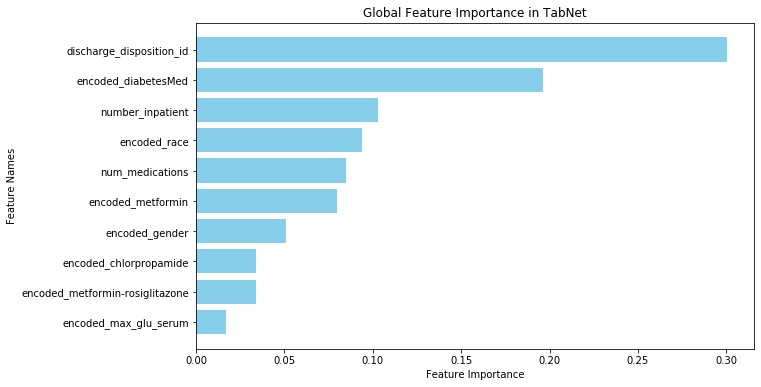

In [18]:
# Plot the most important features
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Global Feature Importance in TabNet")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
plt.show()

As can be observed **"discharge_disposition_id", "encoded_diabetesMed", and "number_inpatient"** have been identified as the most important global features by TabNet. 

discharge_disposition_id: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available [3]. Patient discharged to certain locations, such as another hospital, can be more likely to have severe conditions, increasing the readmission risk.

encoded_diabetesMed: Indicates if there was any diabetic medication prescribed. Actual Values: yes and no [3]. Different  medication types can indicate the severity of patient condition and therefore, determine the readmission likelihood. 

number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter [3]. Patients with multiple previous inpatient visits may have severe conditions, leading to further readmissions.

In [19]:
# local explainability
# extracted from # https://github.com/dreamquark-ai/tabnet
explain_matrix, masks = clf.explain(np.array(X_test))

In [23]:
# Select an instance to visualize (e.g., first sample)
instance_idx = 0  
local_importance = explain_matrix[instance_idx]

# Create DataFrame for sorting
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": local_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)


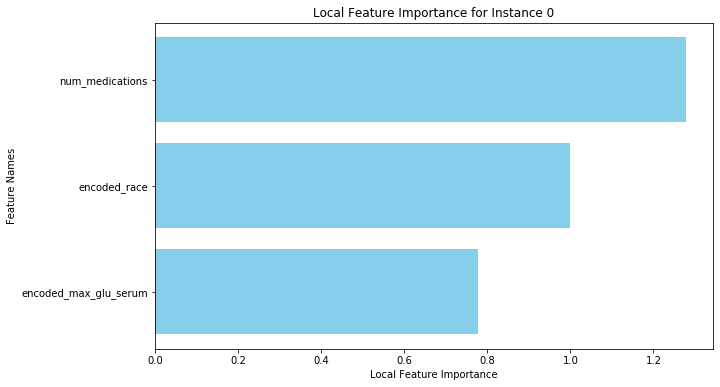

In [24]:
importance_df = importance_df.nlargest(3, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Local Feature Importance")
plt.ylabel("Feature Names")
plt.title(f"Local Feature Importance for Instance {instance_idx}")
plt.gca().invert_yaxis()  # Show most important features at the top
plt.show()

As can be observed **"num_medications", "encoded_race", and "encoded_max_glu_serum"** have been identified as the most important local features for the first datapoint by TabNet. 

num_medications: Number of distinct generic names administered during the encounter [3]. A High number of medications can indicate the severity of patient condition.

encoded_race:  Values: Caucasian, Asian, African American, Hispanic, and other[3]. Race can be determining in access to healthcare, which can result in higher readmission risks in minority populations.

encoded_max_glu_serum: Indicates the range of the result or if the test was not taken. Original Values: >200, >300, normal, and none if not measured [3]. A high value of this variable can indicate poor disease management, increasing readmission likelihood.

## 5. Comparison with XGBoost:

Now, we will compare the performance and explainability analysis of the trained TabNet model with those of an XGBoost model trained on the same data. While XGBoost is a high-performing gradient-boosting model widely used for tabular data, it is often considered a black-box model due to its limited interpretability. In contrast, TabNet’s sequential attention mechanism provides built-in explainability, allowing us to analyze feature importance at both global and local levels. This comparison will help us evaluate the trade-off between predictive accuracy and model interpretability. 

In [27]:
X , y = df.drop("readmitted_binarized",axis=1) , df["readmitted_binarized"]
k = 5
indices = np.arange(len(X))
np.random.shuffle(indices)
folds = np.array_split(indices, k)
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
for i in range(k):
    test_idx = folds[i]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Use all other folds as the training set
    train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    xgb_clf = xgb.XGBClassifier(verbosity=0)

    xgb_clf.fit(X_train.values, y_train.values)
    y_pred = xgb_clf.predict(X_test.values)

    y_prob = xgb_clf.predict_proba(X_test.values)[:,1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test,y_pred)
    test_precision = precision_score(y_test,y_pred)
    test_recall = recall_score(y_test,y_pred)
    
    auc_scores.append(test_auc)
    f1_scores.append(test_f1)
    recall_scores.append(test_precision)
    precision_scores.append(test_recall)
    
print("mean_test_auc",np.mean(auc_scores))
print("mean_test_f1",np.mean(f1_scores))
print("mean_test_precision",np.mean(precision_scores))
print("mean_test_recall",np.mean(recall_scores))

    

mean_test_auc 0.6652168866384062
mean_test_f1 0.047909073085952
mean_test_precision 0.025305003958015777
mean_test_recall 0.4496604166796695


In [28]:
# XGB Feature Importance
# Extract feature importances from the last trained model 
importance_df = pd.DataFrame({
    "Feature": X_train.columns, 
    "Importance": xgb_clf.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)


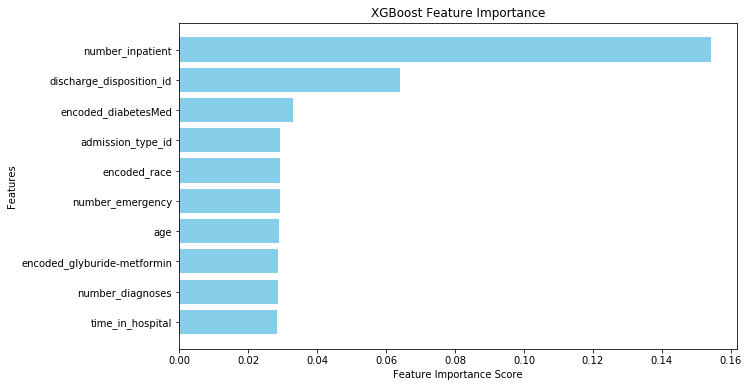

In [29]:
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

As can be observed **"number_inpatient", "discharge_disposition_id", and "encoded_diabetesMed"** have been identified as the most important features by the XGBoost model.

number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter [3]

discharge_disposition_id: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available [3]

encoded_diabetesMed: Indicates if there was any diabetic medication prescribed. Values: yes and no [3]

As can be observed **"number_inpatient","discharge_disposition_id", and "encoded_diabetesMed"** have been critical features in both XGBoost and TabNet model's global feature importance. This demonstrates that these three features can notably contribute to the 30-day readmission risk prediction. 

## References

[1] https://arxiv.org/pdf/1908.07442.pdf

[2] https://github.com/dreamquark-ai/tabnet

[3] https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008